## Import lib.

In [1]:
import os
import zipfile


import cv2
import matplotlib.pyplot as plt 
import numpy as np 
import torch
from torch.utils.data import Dataset

## Import data

In [2]:
with open(".env") as f:
    for line in f:
        key, val = line.strip().split("=")
        os.environ[key] = val

# print("Kaggle user:", os.environ['KAGGLE_USERNAME'])  
# print("Kaggle user:", os.environ['KAGGLE_KEY'])  

In [18]:
!kaggle datasets download -d fantacher/neu-metal-surface-defects-data

Dataset URL: https://www.kaggle.com/datasets/fantacher/neu-metal-surface-defects-data
License(s): other




  0%|          | 0.00/57.4M [00:00<?, ?B/s]
100%|██████████| 57.4M/57.4M [00:00<00:00, 1.55GB/s]


In [3]:
with zipfile.ZipFile("neu-metal-surface-defects-data.zip", "r") as zip_ref:
    zip_ref.extractall("neu_defects")

In [4]:
base_path = r"D:\Metal_surface_defect\neu_defects\NEU Metal Surface Defects Data"
splits = ["train", "test", "valid"]
classes = ["Crazing", "Inclusion", "Patches", "Pitted", "Rolled", "Scratches"]


In [5]:
def get_all_images(base_path, split, classes):
    images = []
    for cls in classes:
        folder = os.path.join(base_path, split, cls)
        images += [os.path.join(folder, img) for img in os.listdir(folder)]
    return images

train_images = get_all_images(base_path, "train", classes)
test_images = get_all_images(base_path, "test", classes)
val_images = get_all_images(base_path, "valid", classes)

print(f"Train images count: {len(train_images)}")
print(f"Test images count: {len(test_images)}")
print(f"Validation images count: {len(val_images)}")

Train images count: 1656
Test images count: 72
Validation images count: 72


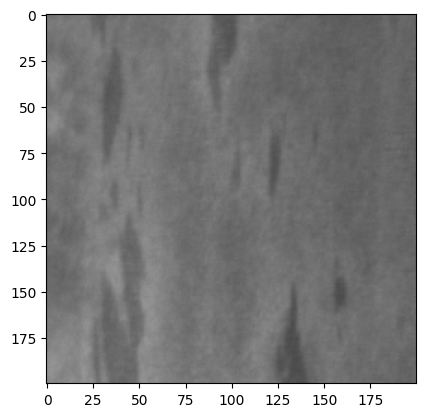

In [16]:
img = cv2.imread(train_images[276]) #0 - 275 change type
plt.imshow(img)

## Image Processing 

In [28]:
def display(x):
    pass 

def resize(img):
    return cv2.resize(img,(720,500))

cv2.namedWindow('image processing')
cv2.createTrackbar('threshold','image processing',0,255,display)

while True:
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    value = cv2.getTrackbarPos('threshold','image processing')
    _,binary = cv2.threshold(gray,value,255,cv2.THRESH_BINARY)

    

    cv2.imshow('image processing',resize(binary))
    if cv2.waitKey(1) & 0xff == ord('e'):
        break

cv2.destroyAllWindows()

## Create labels

In [17]:
classes = ["Crazing", "Inclusion", "Patches", "Pitted", "Rolled", "Scratches"]
class_to_idx = {cls: idx for idx, cls in enumerate(classes)}
class_to_idx

{'Crazing': 0,
 'Inclusion': 1,
 'Patches': 2,
 'Pitted': 3,
 'Rolled': 4,
 'Scratches': 5}

In [12]:
def get_label(image_path):
    for cls in classes:
        if f"\\{cls}\\" in image_path or f"/{cls}/" in image_path:
            return class_to_idx[cls]
    raise ValueError(f"Class not found in path: {image_path}")

In [13]:
train_labels = [get_label(path) for path in train_images]
test_labels = [get_label(path) for path in test_images]
val_labels = [get_label(path) for path in val_images]

In [14]:
print(train_labels[0])
print(train_labels[276])
print(train_labels[552])

0
1
2


## Prepare data